## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow import keras

## Spatial utility functions

In [2]:
# Returns 2D grid location of a SquareId value
# Note: Returns (row, col) NOT (x,y)
def get_grid_location(grid_id):
    
    num_rows = 100
    num_cols = 100
    grid_index = grid_id - 1 #grid id is not 0-indexed
    row_loc = num_rows - 1 - grid_index // num_rows
    col_loc = grid_index % num_rows
    
    return row_loc, col_loc

#get_grid_location(9999)

In [3]:
# Returns index value of grid based on (row, col) numbers specified
def get_grid_id(row_loc, col_loc):
    
    num_rows = 100
    num_cols = 100
    return (num_rows - row_loc - 1)*100 + col_loc + 1
    
#get_grid_id(0,98)

In [4]:
# Return a list of grid index values based on a radius (default 1) around center index value
def get_neighbours(grid_id, radius=1):
    grid_row, grid_col = get_grid_location(grid_id)
    neighbours = []
    for row in range(-radius+grid_row, radius+1+grid_row):
        for col in range(-radius+grid_col, radius+1+grid_col):
            val = get_grid_id(row, col)
            # Restrict neighbours to bounds of data
            if val > 0 and val < 10001:
                neighbours.append(get_grid_id(row,col))
    
    return neighbours

In [5]:
#print(get_neighbours(9899,2))

## Reading data from pickle

In [6]:
df_big = pd.read_pickle("../data_pickles/all.pkl")
print(df_big.shape)
df_big.head()

(160681352, 3)


,SquareId,TimeInterval,InternetActivity
0,1,1383260400000,11.028366
1,1,1383261000000,0.026137
2,1,1383261000000,11.100963
3,1,1383261600000,10.892771
4,1,1383262200000,8.622425


## Preprocess Data

In [7]:
#df = df_big[df_big['SquareId'] == 1]
#df = df.sort_values(by='TimeInterval')
#df = df.drop('SquareId', axis=1)
#df = df.groupby('TimeInterval').sum()
#df.set_index('TimeInterval', inplace=True)
#df.index = pd.to_datetime(df.index, unit='ms')

# ----EXPERIMENT VARIABLES----------------------------------------------------
grid_main = get_grid_id(50,50)
radius = 3
# ----------------------------------------------------------------------------

grid_neighbours = get_neighbours(grid_main, radius)

df = df_big[df_big['SquareId'].isin(grid_neighbours)]
#print(grid_neighbours)

In [8]:
df.size

2722233

In [9]:
df = df.set_index('TimeInterval')
df.index = pd.to_datetime(df.index, unit='ms')

In [10]:
df = df.dropna()
df = df.groupby([df.index, 'SquareId']).sum()

In [11]:
df.head()

InternetActivity
TimeInterval        SquareId                  
2013-10-31 23:00:00 4648            644.778962
                    4649            253.072512
                    4650            275.826982
                    4651            297.583321
                    4652            536.617483

In [12]:
df.index

MultiIndex([('2013-10-31 23:00:00', 4648),
            ('2013-10-31 23:00:00', 4649),
            ('2013-10-31 23:00:00', 4650),
            ('2013-10-31 23:00:00', 4651),
            ('2013-10-31 23:00:00', 4652),
            ('2013-10-31 23:00:00', 4653),
            ('2013-10-31 23:00:00', 4654),
            ('2013-10-31 23:00:00', 4748),
            ('2013-10-31 23:00:00', 4749),
            ('2013-10-31 23:00:00', 4750),
            ...
            ('2014-01-01 22:50:00', 5152),
            ('2014-01-01 22:50:00', 5153),
            ('2014-01-01 22:50:00', 5154),
            ('2014-01-01 22:50:00', 5248),
            ('2014-01-01 22:50:00', 5249),
            ('2014-01-01 22:50:00', 5250),
            ('2014-01-01 22:50:00', 5251),
            ('2014-01-01 22:50:00', 5252),
            ('2014-01-01 22:50:00', 5253),
            ('2014-01-01 22:50:00', 5254)],
           names=['TimeInterval', 'SquareId'], length=437472)

In [13]:
df = df.unstack(level=-1).InternetActivity.rename_axis([None], axis=1)

In [14]:
# Will have to monitor this to make sure it's not too invasive. Otherwise, change to moving average or drop entirely
df = df.fillna(0)

In [15]:
print(df.shape)
df.head()

(8928, 49)


,4648,4649,4650,4651,4652,4653,4654,4748,4749,4750,...,5152,5153,5154,5248,5249,5250,5251,5252,5253,5254
TimeInterval,,,,,,,,,,,,,,,,,,,,,
2013-10-31 23:00:00,644.778962,253.072512,275.826982,297.583321,536.617483,1156.694662,1147.505779,414.876923,256.287502,272.475078,...,298.926459,153.464845,304.445966,472.703826,356.285992,244.134503,381.262867,406.025007,184.048503,402.936741
2013-10-31 23:10:00,577.912685,324.742879,293.180136,301.641776,560.246538,1487.404156,1403.609215,446.253356,279.470463,307.053736,...,311.356217,190.027136,295.268132,586.003432,407.460958,271.165748,570.305667,520.382058,267.357886,353.586029
2013-10-31 23:20:00,575.811594,294.142420,323.099448,337.930668,474.555900,1375.521240,1451.909811,378.101031,262.692168,308.896134,...,252.522845,203.946089,312.732472,442.849629,316.653295,210.414555,325.376368,410.448708,231.019347,343.952379
2013-10-31 23:30:00,583.582016,307.347131,418.112961,405.118904,459.844936,1120.268964,1231.776524,393.740448,271.892114,343.606945,...,241.656499,143.331119,253.809039,387.012007,284.961169,178.877061,335.179832,349.809917,164.163324,306.322764
2013-10-31 23:40:00,586.796030,405.303056,365.943627,392.464672,563.772111,1113.797079,1220.652731,438.869139,282.936935,326.669241,...,393.834019,163.466418,227.548384,338.372897,244.485651,162.327466,296.364824,384.526408,173.801591,300.368497


In [16]:
# Trim Dataset by fraction ------------------------------------------------------------
frac = 0.125
# -------------------------------------------------------------------------------------
df = df.iloc[:int(df.shape[0]*frac)]

<AxesSubplot:xlabel='TimeInterval'>

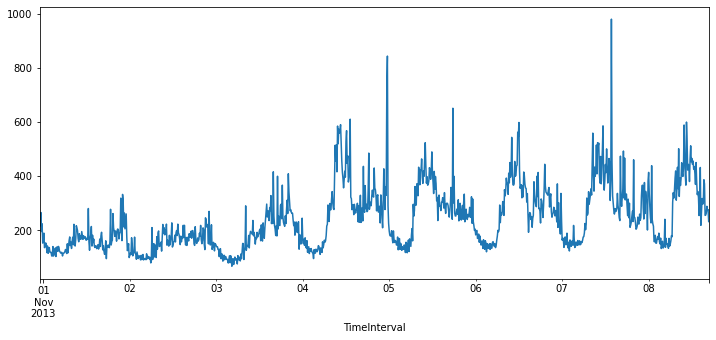

In [17]:
df[grid_main].plot(figsize=(12,5))

## Split data

In [18]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

892 224


In [19]:
# Features
if grid_main in grid_neighbours: grid_neighbours.remove(grid_main)
    
f_columns = grid_neighbours

f_transformer = RobustScaler()
internet_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
internet_transformer = internet_transformer.fit(train[[grid_main]])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train[grid_main] = internet_transformer.transform(train[[grid_main]])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test[grid_main] = internet_transformer.transform(test[[grid_main]])

C:\Users\shahi\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\shahi\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\shahi\AppData\Local\Temp/ipykernel_4700/1363298168.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [20]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [21]:
# The number of past values considered in the LSTM
time_steps = 6

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train[grid_main], time_steps)
X_test, y_test = create_dataset(test, test[grid_main], time_steps)

print(X_train.shape, y_train.shape)

(886, 6, 49) (886,)


## Keras Model

In [22]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                20000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 20,051
Trainable params: 20,051
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/20
25/25 [==============================] - 0s 9ms/step - loss: 0.2309 - val_loss: 0.1568
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1566 - val_loss: 0.1755
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1477 - val_loss: 0.1596
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1728 - val_loss: 0.1559
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1391 - val_loss: 0.1341
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1582 - val_loss: 0.2132
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1270 - val_loss: 0.1494
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1215 - val_loss: 0.1454
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1166 - val_loss: 0.1397
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1149 - val_loss: 0.1355
Epoch 11/20
25/25 [

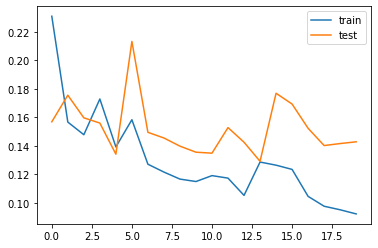

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Predictions

In [26]:
y_pred = model.predict(X_test)

In [27]:
y_train_inv = internet_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = internet_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = internet_transformer.inverse_transform(y_pred)

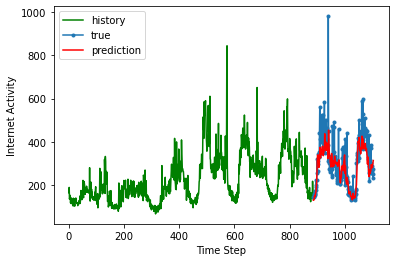

In [28]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

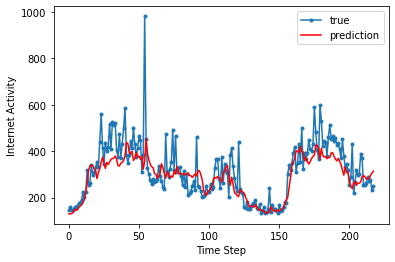

In [29]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [30]:
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print(rmse)

83.19240623204601


## Save data to folder

In [31]:
# PREDICTIONS

# Convert predictions to numpy array
arr = np.array(y_pred_inv.flatten())

# Change name to describe experiment: SPATIOLSTM_<data_length[100,50,12]>_<grid_x>_<grid_y>_<radius>
# ----------------------------------------
filename = "SPATIOLSTM_12_50_50_3.npy"
# ----------------------------------------

folder_name = "../results/SPATIOLSTM/predictions"
f = os.path.join(folder_name, filename)
np.save(f, arr)

# MODEL HISTORY

# Change name to describe experiment: SPATIOLSTM_HISTORY_<data_length[100,50,12]>_<grid_x>_<grid_y>_<radius>
# ----------------------------------------
filename = "SPATIOLSTM_HISTORY_12_50_50_3.npy"
# ----------------------------------------

folder_name = "../results/SPATIOLSTM/training"
f = os.path.join(folder_name, filename)
np.save(f,history.history)